## This Notebook Demonstrate the Calssification of Covid and Normal Cases Using Chest X-ray (CXR) Images

Some part of this program is taken from the follwoing link
https://machinelearningknowledge.ai/keras-implementation-of-vgg16-architecture-from-scratch-with-dogs-vs-cat-data-set/

This notebook contains three major section
1. Building and Train the VGG16 model
2. Loading the saved model and converting it into JSON format
3. Infererencing the program (future use)

### 1. Build the VGG16 model and trian the model

#### Import all the necessary libraries

In [1]:
import cv2
import numpy as np
import os
import shutil
from glob import glob

import matplotlib.pyplot as plt

from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16

import keras

Using TensorFlow backend.


#### Split the dataset into train and test (Skip this section if the dataset is already split)

In [2]:
image_files_covid = glob("cxr_roi/covid/*.png")
image_files_normal = glob("cxr_roi/normal/*.png")

In [3]:
ts = 0.8 #train split

In [4]:
np.random.shuffle(image_files_normal)
train_files_normal = image_files_normal[:int(len(image_files_normal)*ts)]
val_files_normal = image_files_normal[int(len(image_files_normal)*ts):int(len(image_files_normal)*(ts+0.1))]
test_files_normal = image_files_normal[int(len(image_files_normal)*(ts+0.1)):]
print('train: {}, val: {}, test: {}'.format(len(train_files_normal), len(val_files_normal), len(test_files_normal)))

train: 8153, val: 1019, test: 1020


In [5]:
np.random.shuffle(image_files_covid)
train_files_covid = image_files_covid[:int(len(image_files_covid)*ts)]
val_files_covid = image_files_covid[int(len(image_files_covid)*ts):int(len(image_files_covid)*(ts+0.1))]
test_files_covid = image_files_covid[int(len(image_files_covid)*(ts+0.1)):]
print('train: {}, val: {}, test: {}'.format(len(train_files_covid), len(val_files_covid), len(test_files_covid)))

train: 2891, val: 361, test: 362


In [6]:
# Set up the directories 
work_dir = os.path.join(os.getcwd(), 'covid_vs_nor')
train_dir = os.path.join(work_dir, 'train')
val_dir = os.path.join(work_dir, 'val')
test_dir = os.path.join(work_dir, 'test')

if not os.path.exists(work_dir):
    #shutil.rmtree(work_dir)
    os.mkdir(work_dir)

    os.mkdir(train_dir)
    os.mkdir(val_dir)
    os.mkdir(test_dir)

    os.mkdir(os.path.join(train_dir, 'covid'))
    os.mkdir(os.path.join(train_dir, 'normal'))

    os.mkdir(os.path.join(val_dir, 'covid'))
    os.mkdir(os.path.join(val_dir, 'normal'))

    os.mkdir(os.path.join(test_dir, 'covid'))
    os.mkdir(os.path.join(test_dir, 'normal'))

In [ ]:
# copy the images to the respective folder
covid_files = [train_files_covid, val_files_covid, test_files_covid]
dirs = [train_dir, val_dir, test_dir]

for i in range(3):
    for file in covid_files[i]:
        img = cv2.imread(file)
        file_name = os.path.basename(file)
        cv2.imwrite(os.path.join(dirs[i], 'covid', file_name), img)
        
normal_files = [train_files_normal, val_files_normal, test_files_normal]
dirs = [train_dir, val_dir, test_dir]

for i in range(3):
    for file in normal_files[i]:
        img = cv2.imread(file)
        file_name = os.path.basename(file)
        cv2.imwrite(os.path.join(dirs[i], 'normal', file_name), img)

#### Set up the work directories

In [7]:
train_dir = "covid_vs_nor/train"
val_dir = "covid_vs_nor/val"
test_dir = "covid_vs_nor/test"
class_names=os.listdir(train_dir)
print(class_names)

['covid', 'normal']


#### Display sample images

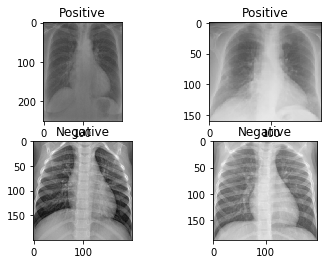

In [8]:
f, axr = plt.subplots(2,2)

axr[0][0].imshow(cv2.imread(np.random.choice(image_files_covid)))
axr[0][0].set_title("Positive")

axr[0][1].imshow(cv2.imread(np.random.choice(image_files_covid)))
axr[0][1].set_title("Positive")

axr[1][0].imshow(cv2.imread(np.random.choice(image_files_normal)))
axr[1][0].set_title("Negative")

axr[1][1].imshow(cv2.imread(np.random.choice(image_files_normal)))
axr[1][1].set_title("Negative")

plt.show()

#### Keras data generator

In [9]:
train_datagen = ImageDataGenerator(zoom_range=0.15,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.15)
test_datagen = ImageDataGenerator()

In [10]:
bs = 16
train_data = train_datagen.flow_from_directory(train_dir, target_size=(224,224),
                                                    batch_size=bs,
                                                    shuffle=True,
                                                    class_mode='categorical')

val_data = train_datagen.flow_from_directory(val_dir, target_size=(224,224),
                                                  batch_size=bs,
                                                  shuffle=True,
                                                  class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_dir, target_size=(224,224),
                                                  batch_size=bs,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 11044 images belonging to 2 classes.
Found 1380 images belonging to 2 classes.
Found 1382 images belonging to 2 classes.


#### Build the VGG16 model

In [11]:
def VGG_16():
    model = Sequential()
    
    model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
    
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    model.add(Dense(2, activation='softmax', name='output'))
    
    return model

#### Compile the model

In [12]:
model = VGG_16()
from keras.optimizers import SGD, Adam
opt = Adam(1e-4)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#### Set up early stopping criteria and modelcekchpoint

In [13]:
es = EarlyStopping(monitor='val_acc', verbose=1, mode='max', patience=20)
mc = ModelCheckpoint(filepath="/Users/Fashiar/Research/Covid-19-Project/Crop_Lung_ROI/models/vgg16/best_model.h5",
                     monitor='val_acc',
                     mode='max',
                     save_best_only=True)

In [ ]:
trained_model = model.fit_generator(train_data,
                                    validation_data=val_data,
                                    epochs=50,
                                    steps_per_epoch=11044//bs,
                                    validation_steps=1380//bs,
                                    verbose=1,
                                    callbacks=[mc,es])

### 2. The model is trained and the best model is saved to the directory (The model achieved approximately 96% accuracy after training the 30 epochs)

You can load the saved model, compile and evaluate the model as follows

In [14]:
# if you want to load the weights in a new notebook
# make sure you have build the "model" object first and then complie the model
# before loading the weights. Otherwise it will through you errors

"""
    model = VGG_16()
    from keras.optimizers import SGD, Adam
    opt = Adam(1e-4)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
"""

model.load_weights("models/vgg16/best_model.h5")

In [ ]:
model.evaluate_generator(test_data, 1382//16)

In [ ]:
model.metrics_names

#### convert the model into JSON format
It is the best practice of converting the model into JSON format to save ti for the interence program in the future

In [ ]:
model_json = model.to_json()
with open("models/vgg16/vgg16_model.json", "w") as json_file:
    json_file.write(model_json)

### 3. Inference the  program

#### Import the necessary libraries if you start inferencing in a new notebook

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from keras.models import model_from_json
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


#### Read the saved JSON model

In [2]:
json_file = open("models/vgg16/vgg16_model.json", "r")
saved_json_model = json_file.read()
json_file.close()

saved_model = model_from_json(saved_json_model)
saved_model.load_weights("models/vgg16/best_model.h5")

#### Compile the model

In [3]:
opt = Adam(1e-4)
saved_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#### Test with any specific image

In [6]:
# Load the image file list
# change "normal" --> "covid" for covid CXRs
test_files = glob.glob("covid_vs_nor/test/covid/*.png")

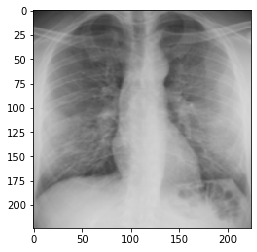

P(covid) vs P(normal): 0.999 vs 0.001


In [7]:
# read any test images
image = cv2.imread(np.random.choice(test_files))
image = cv2.resize(image, (224,224))
preds = saved_model.predict(np.expand_dims(image, axis=0))[0]

plt.imshow(image, cmap='gray')
plt.show()

print("P(covid) vs P(normal): {:.3f} vs {:.3f}".format(preds[0], preds[1]))